In [20]:
# @title
from IPython.display import HTML

HTML("""
<div style="display: flex; justify-content: space-between; align-items: center;">

    <div style="flex: 1; text-align: left;">
        <h1 style="font-size: 34px; color:#ff6600; margin: 0;">
            Online Retail Customer Segmentation
        </h1>
        <p style="font-size: 18px; color:#555; margin-top: 8px;">
            RFM • K-Means • Hierarchical Clustering
        </p>
    </div>

</div>
""")

In [74]:
# @title
from IPython.display import display, HTML

display(HTML('''
<center>
  <img src="https://www.marketingevolution.com/hs-fs/hubfs/customer-segmentation.jpg?width=1100&name=customer-segmentation.jpg"
       alt="Customer Segmentation"
       width="600">
</center>
'''))


## 📌 Dataset Columns Explanation (Table)

| Column       | Description |
|--------------|-------------|
| **InvoiceNo** | Unique identifier for each transaction. If it starts with a letter (e.g., "C"), it indicates a canceled or returned invoice. |
| **StockCode** | Product code used to identify each item in the inventory. |
| **Description** | Name or description of the purchased product. |
| **Quantity** | Number of units purchased. Negative values indicate returned items. |
| **InvoiceDate** | Date and time of the transaction. Used for calculating Recency in RFM. |
| **UnitPrice** | Price of one unit of the product. |
| **CustomerID** | Unique identifier for each customer. Missing values indicate unknown customers. |
| **Country** | Country where the customer is located. Useful for geographic segmentation. |


##🧾 **Profiling the Dataset**

In [21]:
#!pip install ydata_profiling
#!pip install missingno

In [75]:
from ydata_profiling import ProfileReport
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv('/content/OnlineRetail.csv', encoding='ISO-8859-1')
profile=ProfileReport(df,title='Profiling Report')
profile.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:17<00:00,  2.23s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [76]:
profile

##🧭 **Data Overview**

In [24]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [25]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74293 entries, 0 to 74292
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    74293 non-null  object 
 1   StockCode    74293 non-null  object 
 2   Description  74104 non-null  object 
 3   Quantity     74292 non-null  float64
 4   InvoiceDate  74292 non-null  object 
 5   UnitPrice    74292 non-null  float64
 6   CustomerID   46204 non-null  float64
 7   Country      74292 non-null  object 
dtypes: float64(3), object(5)
memory usage: 4.5+ MB


In [27]:
df.shape

(74293, 8)

In [28]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,74292.000000,74292.000000,46204.000000
mean,8.312550,5.659764,15351.134794
std,388.608396,137.089099,1765.264909
min,-74215.000000,0.000000,12346.000000
25%,1.000000,1.250000,13959.000000
50%,2.000000,2.510000,15311.000000
75%,8.000000,4.210000,16943.000000
max,74215.000000,16888.020000,18283.000000


In [29]:
df.describe(include='O')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,74293,74293,74104,74292,74292
unique,3288,3012,2946,2951,28
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,06-12-2010 16:57,United Kingdom
freq,675,394,402,675,69023


In [30]:
df.duplicated().sum()

np.int64(718)

In [31]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,189
Quantity,1
InvoiceDate,1
UnitPrice,1
CustomerID,28089
Country,1


In [32]:
# ---- Show all columns & rows without truncation ----
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# ---- Calculate missing values ----
missing_values = df.isnull().sum()

# ---- Calculate percentage of missing values ----
total_rows = df.shape[0]
missing_percentage = (missing_values / total_rows) * 100

# ---- Create a new DataFrame with missing values and percentage ----
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage %': missing_percentage})
missing_df

,Missing Values,Percentage %
InvoiceNo,0,0.000000
StockCode,0,0.000000
Description,189,0.254398
Quantity,1,0.001346
InvoiceDate,1,0.001346
UnitPrice,1,0.001346
CustomerID,28089,37.808407
Country,1,0.001346


## 🧹 **Data Cleaning**

In [33]:
df.rename(columns={
    'InvoiceNo': 'Invoice_ID',
    'StockCode': 'Product_Code',
    'InvoiceDate': 'Invoice_Date',
    'UnitPrice': 'Unit_Price',
    'CustomerID': 'Customer_ID'
}, inplace=True)

# Check the new column names
print(df.columns)

Index(['Invoice_ID', 'Product_Code', 'Description', 'Quantity', 'Invoice_Date',
       'Unit_Price', 'Customer_ID', 'Country'],
      dtype='object')


In [34]:
df.drop_duplicates(inplace=True)

In [35]:
df.shape

(73575, 8)

<Figure size 600x400 with 0 Axes>

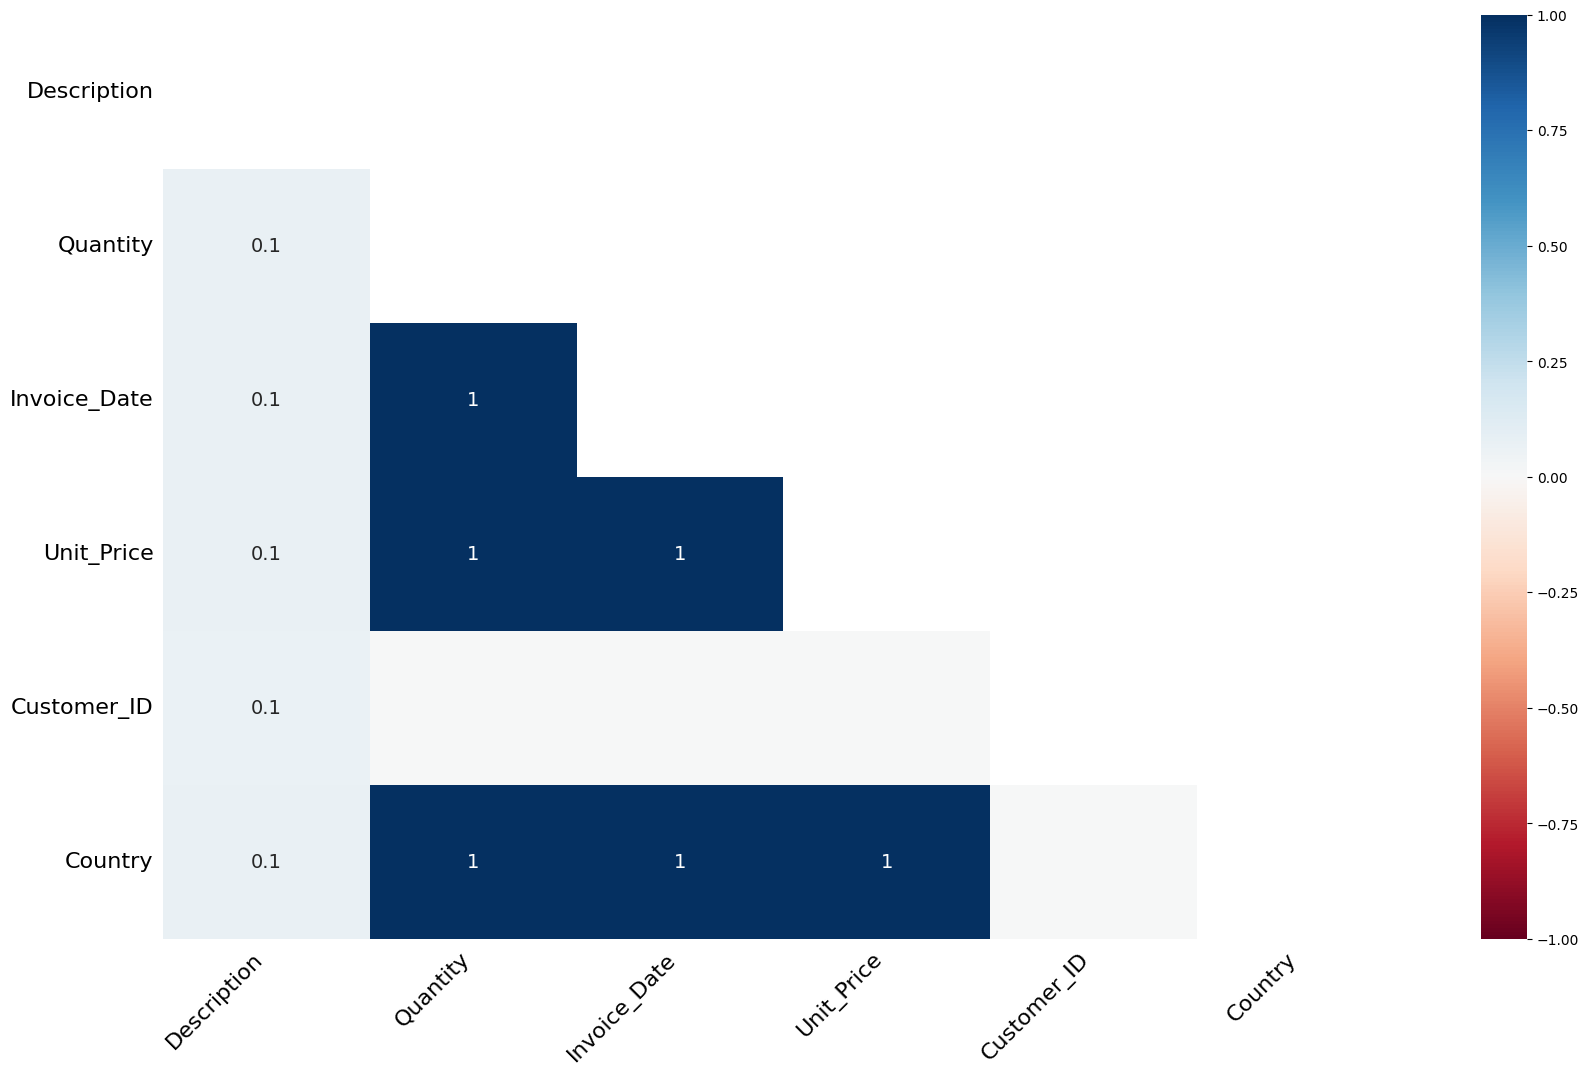

In [36]:
import matplotlib.pyplot as plt
import missingno as msno

plt.figure(figsize=(6, 4))  # حجم أصغر (العرض × الطول)
msno.heatmap(df)
plt.show()

In [37]:
df[df['Country'].isnull()]

,Invoice_ID,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country
74292,542419,22505,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df = df.drop(df[df['Country'].isnull()].index)

In [39]:
df[df['Country'].isnull()]

,Invoice_ID,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country


In [40]:
df.isnull().sum()

,0
Invoice_ID,0
Product_Code,0
Description,188
Quantity,0
Invoice_Date,0
Unit_Price,0
Customer_ID,28079
Country,0


In [41]:
# Fill Description missing values with 'Unknown'
df['Description'].fillna('Unknown', inplace=True)

# Drop rows where CustomerID or InvoiceDate is missing
df.dropna(subset=['Customer_ID'], inplace=True)

In [42]:
df.shape

(45495, 8)

In [43]:
df.sample()

,Invoice_ID,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country
32184,539044,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24.0,15-12-2010 15:47,0.55,15727.0,United Kingdom


###Data Type Conversion

In [44]:
df.dtypes

,0
Invoice_ID,object
Product_Code,object
Description,object
Quantity,float64
Invoice_Date,object
Unit_Price,float64
Customer_ID,float64
Country,object


In [45]:
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'], errors='coerce')

In [46]:
# يتحقق إذا كل القيم أعداد صحيحة (حتى لو float)
is_integer = (df[['Quantity', 'Customer_ID']] % 1 == 0).all()
print(is_integer)

Quantity       True
Customer_ID    True
dtype: bool


In [47]:
df['Quantity'] = df['Quantity'].astype('Int64')
df['Customer_ID'] = df['Customer_ID'].astype('Int64')

In [48]:
df.dtypes

,0
Invoice_ID,object
Product_Code,object
Description,object
Quantity,Int64
Invoice_Date,datetime64[ns]
Unit_Price,float64
Customer_ID,Int64
Country,object


####Removing Invalid Unit Prices

In [49]:
df = df[df['Unit_Price'] > 0]

In [50]:
df.shape

(45489, 8)

##📊 **Visualization**

In [51]:
df.columns

Index(['Invoice_ID', 'Product_Code', 'Description', 'Quantity', 'Invoice_Date',
       'Unit_Price', 'Customer_ID', 'Country'],
      dtype='object')

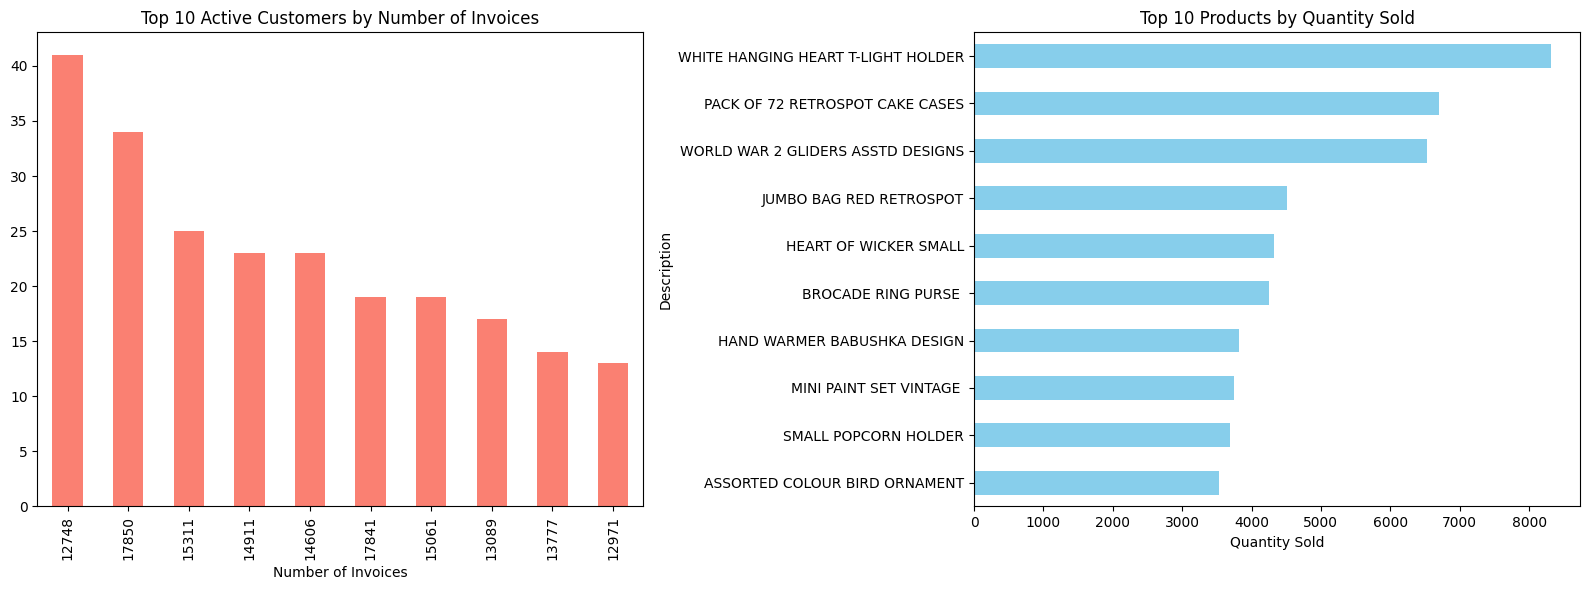

In [52]:
import matplotlib.pyplot as plt

# بيانات Top 10 Products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# بيانات Top 10 Customers
top_customers = df.groupby('Customer_ID')['Invoice_ID'].nunique().sort_values(ascending=False).head(10)

# إنشاء subplot
fig, axes = plt.subplots(1, 2, figsize=(16,6))  # صف واحد وعمودين

# الرسم الأول: Top Customers على اليسار
top_customers.plot(kind='bar', ax=axes[0], color='salmon')
axes[0].set_title("Top 10 Active Customers by Number of Invoices")
axes[0].set_xlabel("Number of Invoices")
axes[0].tick_params(axis='x')

# الرسم الثاني: Top Products على اليمين
top_products.plot(kind='barh', ax=axes[1], color='skyblue')
axes[1].set_title("Top 10 Products by Quantity Sold")
axes[1].invert_yaxis()  # لجعل الأعلى في الأعلى
axes[1].set_xlabel("Quantity Sold")
axes[1].tick_params(axis='y')

plt.tight_layout()
plt.show()

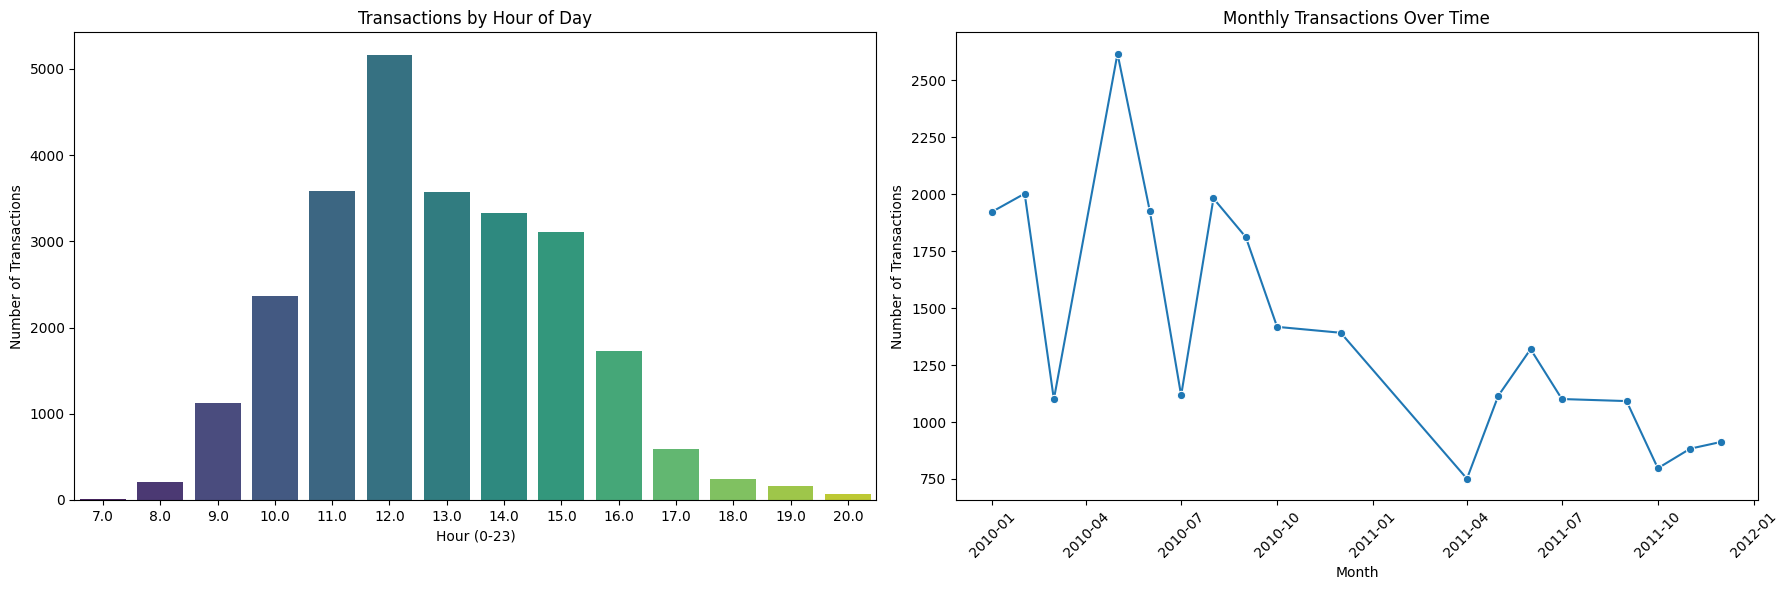

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# تأكد من تحويل العمود datetime
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'], errors='coerce')

# حساب عدد المعاملات لكل ساعة
hour_counts = df['Invoice_Date'].dt.hour.value_counts().sort_index()

# حساب عدد المعاملات لكل شهر
monthly_transactions = df.groupby(df['Invoice_Date'].dt.to_period('M')).size().reset_index(name='Transactions')
monthly_transactions['Month'] = monthly_transactions['Invoice_Date'].dt.to_timestamp()

# إعداد subplot (1 صف × 2 عمود)
fig, axes = plt.subplots(1, 2, figsize=(18,6))

# ----------------- Hourly Transactions -----------------
sns.barplot(x=hour_counts.index, y=hour_counts.values, palette='viridis', ax=axes[0])
axes[0].set_title('Transactions by Hour of Day')
axes[0].set_xlabel('Hour (0-23)')
axes[0].set_ylabel('Number of Transactions')

# ----------------- Monthly Transactions -----------------
sns.lineplot(x=monthly_transactions['Month'], y=monthly_transactions['Transactions'], marker='o', ax=axes[1])
axes[1].set_title('Monthly Transactions Over Time')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Transactions')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [54]:
import plotly.express as px

# 🔹 نحسب عدد المعاملات لكل دولة
country_counts = df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Transactions']

# 🔹 خريطة تفاعلية
fig = px.choropleth(
    country_counts,
    locations="Country",
    locationmode="country names",  # نستخدم أسماء الدول
    color="Transactions",
    hover_name="Country",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Transactions by Country"
)

fig.show()

##**RFM Analysis**

In [55]:
import pandas as pd

snapshot_date = df['Invoice_Date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer_ID').agg({
    'Invoice_Date': lambda x: (snapshot_date - x.max()).days,
    'Invoice_ID': 'nunique',
    'Unit_Price': lambda x: (x * df.loc[x.index, 'Quantity']).sum()
}).reset_index()

rfm.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,Customer_ID,Recency,Frequency,Monetary
0,12346,NaN,2,0.00
1,12347,508.0,2,1187.18
2,12348,NaN,2,1120.24
3,12356,NaN,1,2271.62
4,12359,1.0,1,547.50


In [56]:
rfm.isnull().sum()

,0
Customer_ID,0
Recency,443
Frequency,0
Monetary,0


In [57]:
rfm_clean = rfm.dropna()

###Scaling RFM Metrics

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clean[['Recency', 'Frequency', 'Monetary']])

##**K-Means Clustering**

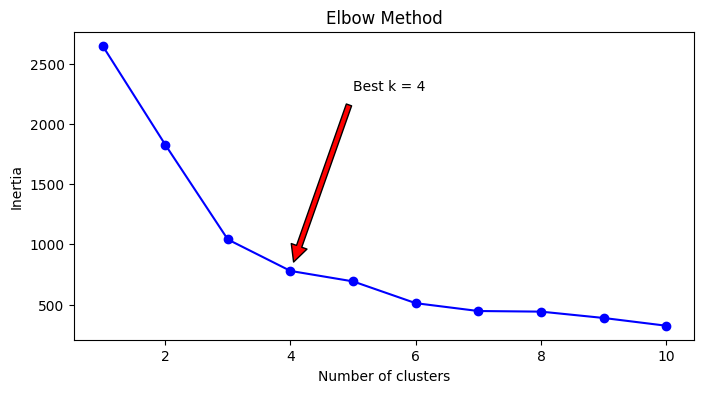

In [59]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, 'bo-', label='Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Add arrow to show best k
best_k = 4
plt.annotate('Best k = 4',
             xy=(best_k, inertia[best_k-1]),
             xytext=(best_k+1, inertia[best_k-1]+1500),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

In [60]:
from sklearn.cluster import KMeans

# Set the best number of clusters
best_k = 4

# Fit KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42)
rfm_clean['Cluster'] = kmeans.fit_predict(rfm_scaled)

# View cluster assignment
rfm_clean.head()

,Customer_ID,Recency,Frequency,Monetary,Cluster
1,12347,508.0,2,1187.18,0
4,12359,1.0,1,547.50,1
7,12383,1.0,3,1240.63,1
8,12386,184.0,2,401.90,1
10,12393,31.0,2,639.50,1


In [61]:
rfm_clean['Cluster'].value_counts().sort_index()

,count
Cluster,
0,541
1,328
2,8
3,6


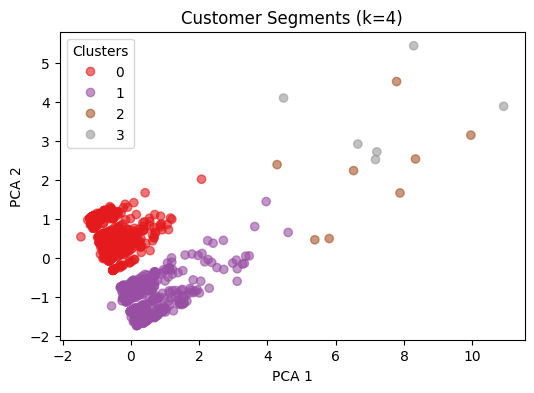

In [62]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce RFM data to 2D
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Scatter plot of clusters
plt.figure(figsize=(6,4))
scatter = plt.scatter(rfm_pca[:,0], rfm_pca[:,1],
                      c=rfm_clean['Cluster'], cmap='Set1', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Customer Segments (k=4)')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [63]:
from sklearn.metrics import silhouette_score

score = silhouette_score(rfm_scaled, rfm_clean['Cluster'])
print("Silhouette Score:", score)

Silhouette Score: 0.5385721069937089


##**hierarchical clustering**

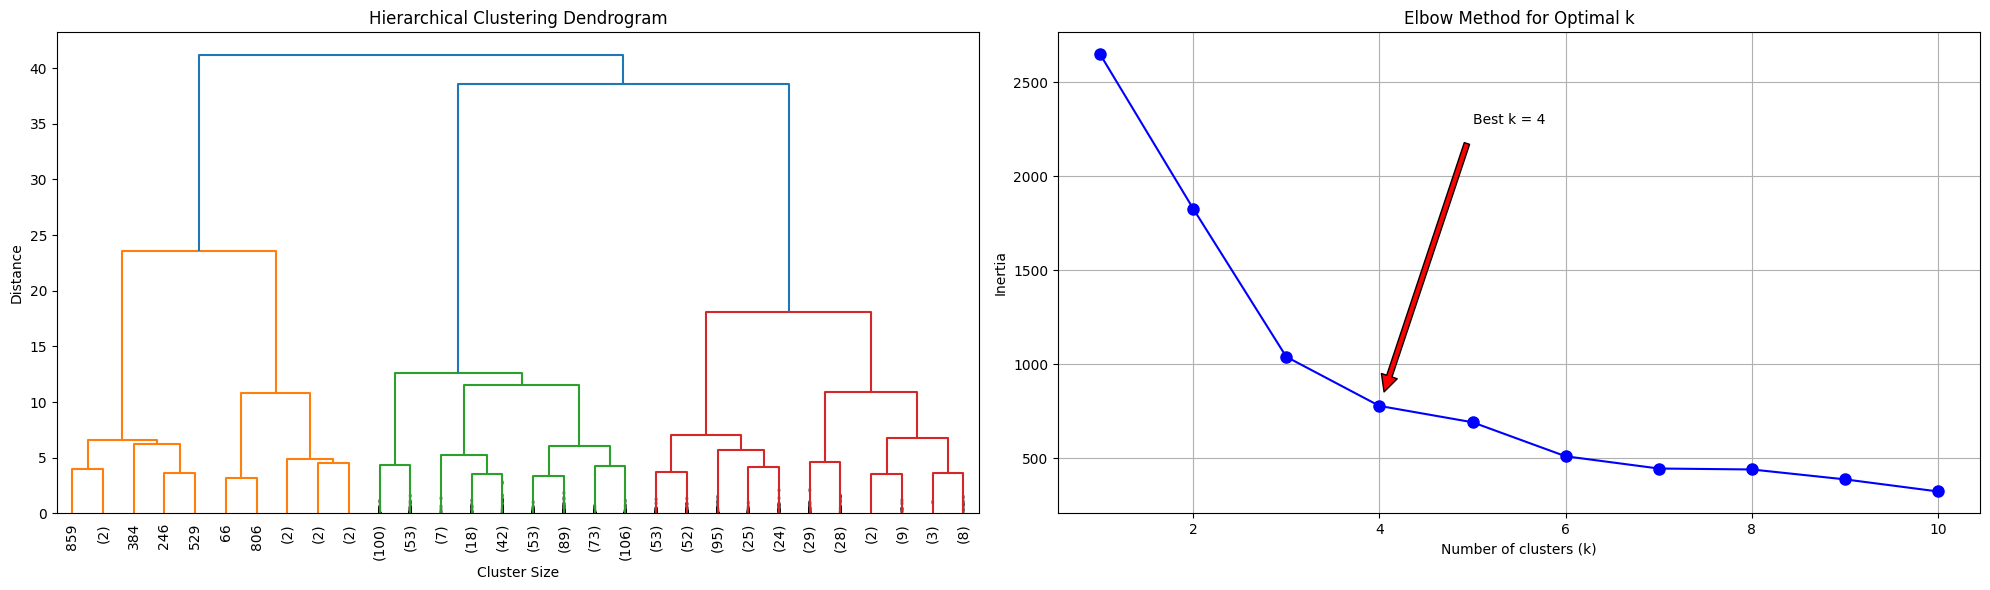

In [64]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

# Compute linkage matrix for hierarchical clustering
Z = linkage(rfm_scaled, method='ward')

# Compute inertia for KMeans
K = range(1, 11)
inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

best_k = 4  # اخترت يدويًا بعد النظر في الـ elbow

# Create figure with 2 subplots: Dendrogram (left) and Elbow (right)
fig, axes = plt.subplots(1, 2, figsize=(20,6))

# --- Subplot 1: Dendrogram ---
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True, ax=axes[0])
axes[0].set_title('Hierarchical Clustering Dendrogram')
axes[0].set_xlabel('Cluster Size')
axes[0].set_ylabel('Distance')

# --- Subplot 2: Elbow Plot ---
axes[1].plot(K, inertia, 'bo-', markersize=8)
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Inertia')
axes[1].set_title('Elbow Method for Optimal k')
axes[1].annotate(f'Best k = {best_k}',
                 xy=(best_k, inertia[best_k-1]),
                 xytext=(best_k+1, inertia[best_k-1]+1500),
                 arrowprops=dict(facecolor='red', shrink=0.05))
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [65]:
from sklearn.cluster import AgglomerativeClustering

# Number of clusters
n_clusters = 4

# Fit hierarchical clustering
hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
rfm_clean['HC_Cluster'] = hc.fit_predict(rfm_scaled)

# Check the distribution of clusters
print(rfm_clean['HC_Cluster'].value_counts().sort_index())

HC_Cluster
0    328
1      8
2    541
3      6
Name: count, dtype: int64


In [66]:
from sklearn.metrics import silhouette_score

# Silhouette Score بعد تطبيق Hierarchical Clustering
hc_score = silhouette_score(rfm_scaled, rfm_clean['HC_Cluster'])
print("Silhouette Score for Hierarchical Clustering:", hc_score)

Silhouette Score for Hierarchical Clustering: 0.5385721069937089


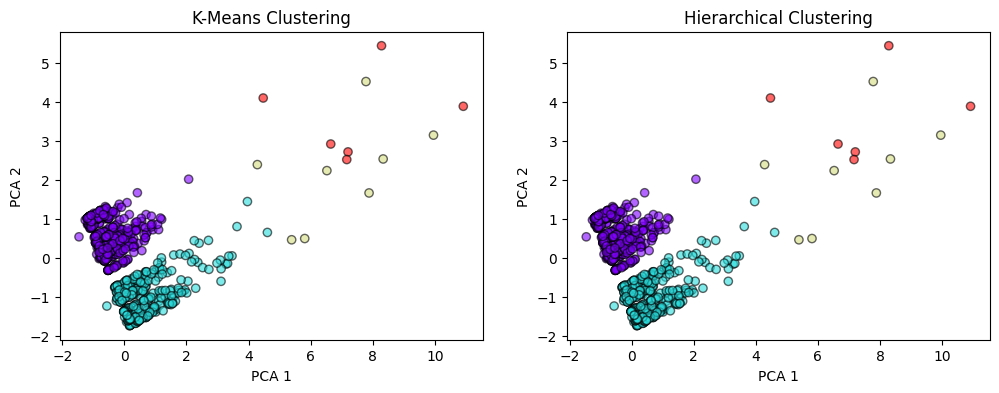

In [68]:
import numpy as np

# ترتيب الكلاسترات حسب حجم كل cluster
def order_clusters(labels):
    counts = np.bincount(labels)
    order = np.argsort(-counts)  # ترتيب تنازلي
    mapping = {old:new for new, old in enumerate(order)}
    return np.array([mapping[x] for x in labels])

y_km_ord = order_clusters(rfm_clean['Cluster'])
y_hc_ord = order_clusters(rfm_clean['HC_Cluster'])

# الآن يمكن رسمهما مع cmap واحد
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.scatter(rfm_pca[:,0], rfm_pca[:,1], c=y_km_ord, cmap='rainbow', edgecolor='black', alpha=0.6)
ax1.set_title('K-Means Clustering')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')

ax2 = fig.add_subplot(122)
ax2.scatter(rfm_pca[:,0], rfm_pca[:,1], c=y_hc_ord, cmap='rainbow', edgecolor='black', alpha=0.6)
ax2.set_title('Hierarchical Clustering')
ax2.set_xlabel('PCA 1')
ax2.set_ylabel('PCA 2')

plt.show()

In [73]:
# @title
from IPython.display import display, HTML

display(HTML('''
<center>
  <img src="https://thumbs.dreamstime.com/b/customer-segmentation-target-audience-analysis-flat-vector-isometric-illustration-audience-segmentation-online-marketing-239070790.jpg"
       alt="Customer Segmentation"
       width="600">
</center>
'''))
